## Sentiment Analysis Guide

This notebook is a guide to visualizing the sentiment composition of the articles under consideratino. To ensure accuracy, please check the quality of the data before proceeding — ideally, the text should be pre-processed. A code cell containing the pre-processing algorithm is included in the NGramsGuide.ibynb notebook, so run it if needed.

## Setup

Import the necessary packages. It may be necessary to ![install](https://packaging.python.org/en/latest/tutorials/installing-packages/) the packages if they are not already in your Python kernel.

In [91]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer

Load the data set(s). Change the argument to include the path on your local computer that leads to the file. For example, if the file is in your Downloads folder, the path may look like /Users/firstnamelastname/Downloads/Bridging Racial Violence Compiled Data.xlsx.

In [92]:
articles = pd.read_csv('/Users/clairefenton/Desktop/Emory/BRV Research/Data/ATL_1941_new_preprocessing.csv')

## Retrieve Sentiment Analysis Scores

The sentiment analyzer from the nltk package analyzes each article and provides it four different scores:
* Positive: the proportion of words in the article that have positive sentiment
* Negative: the proportion of words in the article that have negative sentiment
* Neutral: the proportion of words in the article that have neutral sentiment
* Compound: a score ranging from [-1, 1] that scores the article as a whole, with -1 being negative and +1 being positive

Take the scores with a grain of salt, as the sentiment analyzer is far from perfect! Use the scores to look at big picture aggregates rather than comparing at the individual level. 

The function `score_sentiment` will provide a data frame containing all the sentiment scores for each article and takes two arguments:
* df: a data frame
* column: a string value representing the name of the column containing the pre-processed text

In [93]:
sia = SentimentIntensityAnalyzer()
neg = []
pos = []
neu = []
comp = []

def score_sentiment(df, column):
    for i in range(len(df)):
        scores = sia.polarity_scores(df[column].iloc[i])
        neg.append(scores['neg'])
        pos.append(scores['pos'])
        neu.append(scores['neu'])
        comp.append(scores['compound'])
    d = {'Positive': pos, 'Negative': neg, 'Neutral': neu, 'Compound': comp}
    scores = pd.DataFrame(data=d)
    return scores

If desired, filter the articles to only examine those containing instances of racial violence.

In [94]:
articles_violence = articles[articles['entry'] == 1]
scores = score_sentiment(articles_violence, 'text_x')
scores

,Positive,Negative,Neutral,Compound
0,0.051,0.196,0.753,-0.9977
1,0.138,0.128,0.734,-0.6808
2,0.061,0.216,0.723,-0.9958
3,0.026,0.217,0.756,-0.9902
4,0.054,0.131,0.815,-0.9732
...,...,...,...,...
147,0.069,0.131,0.800,-0.8402
148,0.048,0.144,0.808,-0.9729
149,0.068,0.084,0.848,-0.8902
150,0.038,0.218,0.744,-0.9628


## Visualizing Sentiment Scores

The following cell blocks contain code for creating histograms representing the distribution of sentiment scores contained in the article. The source data is the data frame returned from `score_sentiment`. The graph should be fairly self-explanatory, and any of the aesthetic parameters can be modified as desired. 

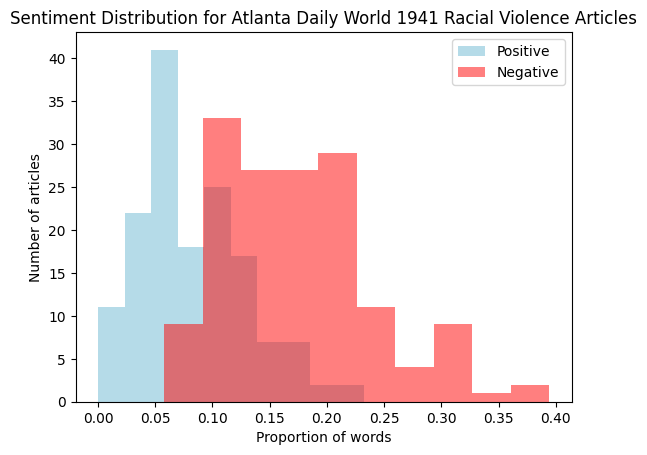

In [95]:
plt.hist(scores['Positive'], label='Positive', alpha=0.9, color='lightblue')
plt.hist(scores['Negative'], label='Negative', alpha=0.5, color='red')
plt.xlabel('Proportion of words')
plt.ylabel('Number of articles')
plt.title('Sentiment Distribution for Atlanta Daily World 1941 Racial Violence Articles')
plt.legend()

An interesting point of comparison is that between the articles containing instances of racial violence and those without.

In [96]:
articles_nonviolence = articles[articles['entry'] == 0]
non_violent_scores = score_sentiment(articles_nonviolence, 'text_x')

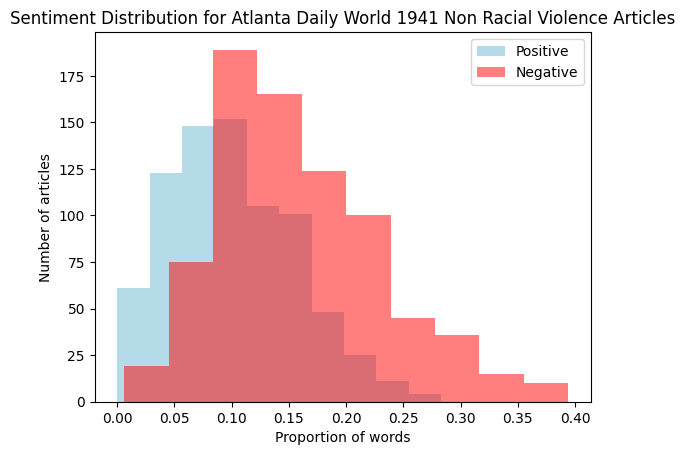

In [97]:
plt.hist(non_violent_scores['Positive'], label='Positive', alpha=0.9, color='lightblue')
plt.hist(non_violent_scores['Negative'], label='Negative', alpha=0.5, color='red')
plt.xlabel('Proportion of words')
plt.ylabel('Number of articles')
plt.title('Sentiment Distribution for Atlanta Daily World 1941 Non Racial Violence Articles')
plt.legend()

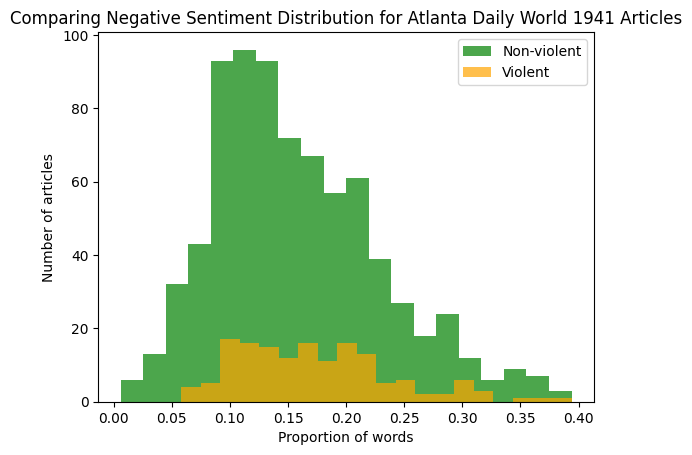

In [98]:
plt.hist(non_violent_scores['Negative'], label='Non-violent', alpha=0.7, color='green', bins=20)
plt.hist(scores['Negative'], label='Violent', alpha=0.7, color='orange', bins=20)
plt.xlabel('Proportion of words')
plt.ylabel('Number of articles')
plt.title('Comparing Negative Sentiment Distribution for Atlanta Daily World 1941 Articles')
plt.legend()

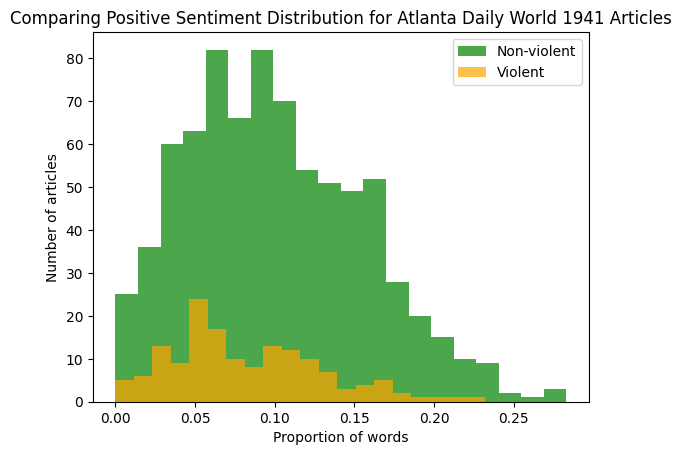

In [99]:
plt.hist(non_violent_scores['Positive'], label='Non-violent', alpha=0.7, color='green', bins=20)
plt.hist(scores['Positive'], label='Violent', alpha=0.7, color='orange', bins=20)
plt.xlabel('Proportion of words')
plt.ylabel('Number of articles')
plt.title('Comparing Positive Sentiment Distribution for Atlanta Daily World 1941 Articles')
plt.legend()

In [100]:
print('Mean negative sentiment score for non violent articles: ', non_violent_scores['Negative'].mean())
print('Mean negative sentiment score for violent articles: ', scores['Negative'].mean())

Mean negative sentiment score for non violent articles:  0.15816709511568125
Mean negative sentiment score for violent articles:  0.174625


When we examine the mean negative sentiment scores of each group, the non-violent group has slightly less negative sentiment than the violent group — but is this difference statistically significant? To check, perform a [t-test](https://www.scribbr.com/statistics/students-t-table/) for proportion difference between two differently sized populations.

The function `t_test` returns a numeric value containing the t-test score between the two groups and takes the following arguments:
* df1: data set containing one group for comparison
* df2: data set containing the second group for comparison
* sentiment_type: a string value of either 'Positive', 'Negative', 'Neutral' or 'Compound' representing the comparison statistic

The function `degrees_of_freedom` calculates the degrees of freedom for a comparison to determine which threshold value to use to determine significance. It takes the same arguments and returns a numeric value.

In [101]:
def t_test(df1, df2, sentiment_type):
    mu1 = df1[sentiment_type].mean()
    var1 = np.var(df1[sentiment_type])
    n1 = len(df1)

    mu2 = df2[sentiment_type].mean()
    var2 = np.var(df2[sentiment_type])
    n2 = len(df2)

    t_value = (mu1-mu2)/np.sqrt((var1/n1) + (var2/n2))

    return t_value

In [102]:
def degrees_of_freedom(df1, df2, sentiment_type):
    var1 = np.var(df1[sentiment_type])
    n1 = len(df1)

    var2 = np.var(df2[sentiment_type])
    n2 = len(df2)

    num = ((var1**2/n1) + (var2**2/n2))**2
    denom1 = ((var1**2/n1)**2/(n1-1))
    denom2 = ((var2**2/n2)**2/(n2-1))

    return num/(denom1 + denom2)

T-test for negativity between article groups:

In [103]:
print('T-test for negativity result: ', t_test(non_violent_scores, scores, 'Negative'))
print('Degrees of freedom: ', degrees_of_freedom(non_violent_scores, scores, 'Negative'))

T-test for negativity result:  -2.757382105892128
Degrees of freedom:  244.5652764566976


Given the degrees of freedom is over 100, our threshold values are 1.984 and -1.984 at the 0.05 signifiance level. The t-test result is -3.341, so the non violent articles have significantly less negative sentiment than the violent articles.

T-test for positivity between article groups:

In [104]:
print('T-test for positivity: ', t_test(non_violent_scores, scores, 'Positive'))

T-test for positivity:  4.209270919781524


The t-test result is 5.083, so the non violent articles have significantly more positive sentiment than the violent articles.

T-test for neutral sentiment between article groups:

In [105]:
print('T-test for neutral scores: ', t_test(non_violent_scores, scores, 'Neutral'))

T-test for neutral scores:  -0.2598285610628474


The t-test result is -0.317, so there is not a significant difference in negative sentiment between the two groups.

T-test for compound score between article groups:

In [106]:
print('T-test for compound scores: ',t_test(non_violent_scores, scores, 'Compound'))

T-test for compound scores:  5.935199927017676


The t-test result is 7.078, so the the non violent scores have significantly more positive compound scores.

## Additional Notes

Comparisons can also be made across publications, across sentiment scores and publications, across years and any other point of comparison that might prove useful. The differences in proportions are likely to be small at first glance, so performing tests of statistical significance is impmortant for distinguishing whether or not a finding is present. 